In [1]:
# Shallow ice flow model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import firedrake 

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


/Users/bkyanjo3/firedrake/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Text(0.5, 1.0, 'Mesh')

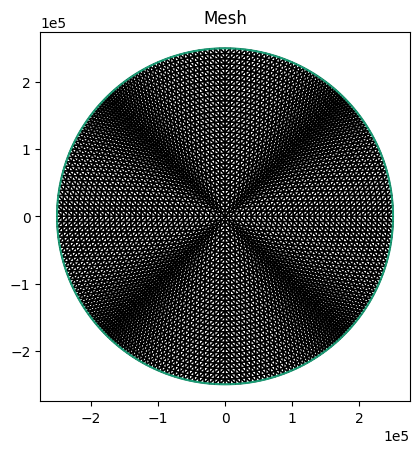

In [3]:
# Geometry
mesh = firedrake.UnitDiskMesh(5)
R = 250e3
mesh.coordinates.dat.data[:] *= R

import icepack.plot

fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
axes.set_title("Mesh")

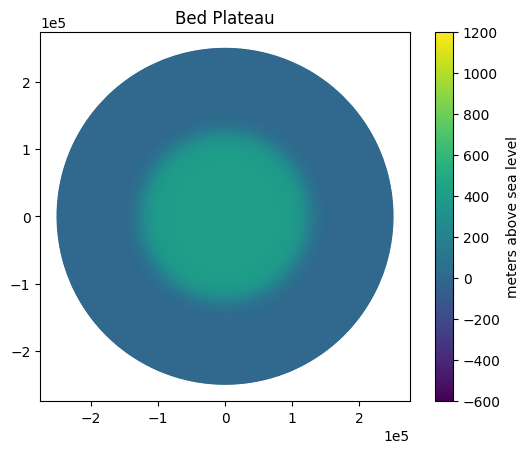

In [4]:
# input data: ice bed, surface, thickness, velocity, and accumulation rate
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2) 
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

from firedrake import sqrt, exp, Constant, Function

x, y = firedrake.SpatialCoordinate(mesh)
r = sqrt(x**2 + y**2)

# Plateau elevation
b_base = Constant(400)

# Max Elevation
b_max = Constant(1400)

# Radius of the plateau interior
ro = 125e3

# Radius of the ridge
Ro = Constant(200e3)

def tanh(z):
    return (exp(z) - exp(-z))/(exp(z) + exp(-z))

def theta(z):
    return (tanh(z) + 1)/2

def sech(z):
    return 2/(exp(z) + exp(-z))

# make a plateau on which the ice sheet sits
a = Constant(50e3)
eta = (sqrt(x**2 + y**2) - ro)/a

b_expr_plateau = b_base * (1 - theta(3*eta))
b = Function(Q).interpolate(b_expr_plateau)

fig,axes = icepack.plot.subplots()
kw = {"vmin": -600, "vmax":1200}
colors = firedrake.tripcolor(b, axes=axes, shading="gouraud", cmap="viridis", **kw)
axes.set_title("Bed Plateau")
fig.colorbar(colors, label="meters above sea level")


Text(0.5, 1.0, 'Bed Plateau and Ridge')

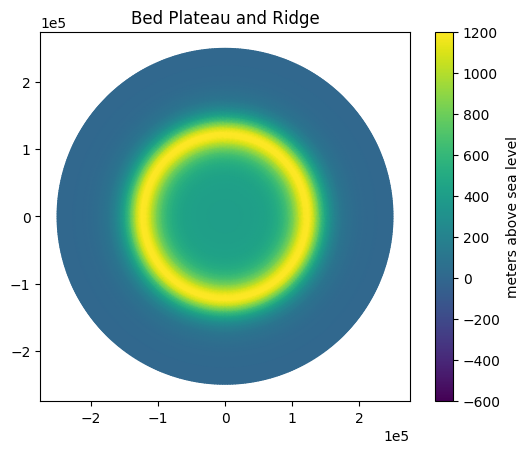

In [5]:
# Add a ridge that runs along the edge of the plateau
zta = (r- Ro)/a

b_expr_ridge = (b_max - b_base) * sech(3*eta)
b_expr = b_expr_plateau + b_expr_ridge
b = Function(Q).interpolate(b_expr)

fig, axes = icepack.plot.subplots()
contors = firedrake.tripcolor(b, axes=axes, shading="gouraud", cmap="viridis", **kw)
fig.colorbar(contors, label="meters above sea level")
axes.set_title("Bed Plateau and Ridge")

Text(0.5, 1.0, 'Bed Plateau, \n Ridge, and Valleys')

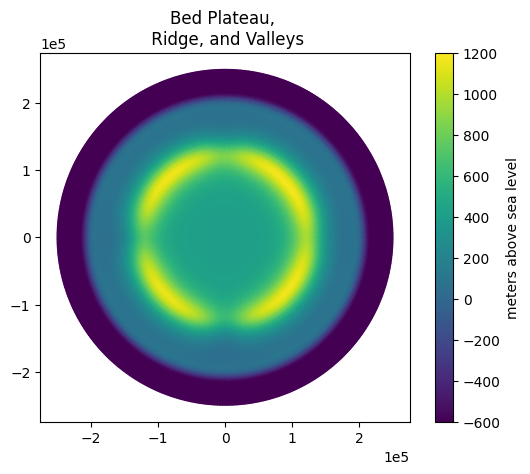

In [6]:
# cut valleys into the ridge to get bed topography
rho1 = Constant(1/4)
mu1 = 1- rho1*theta(3 * (x - ro / 4) / a) * sech(2 * y / a)

rho2 = Constant(3/8)
mu2 = 1 - rho2 * theta(3 * (y - ro / 4) / a) * sech(2 * x / a)

rho3 = Constant(1/2)
mu3 = 1 - rho3 * theta(3 * (-x + ro / 4) / a) * sech(2 * y / a)

rho4 = Constant(5/8)
mu4 = 1 - rho4 * theta(3 * (-y + ro / 4) / a) * sech(2 * x / a)

mu = mu1 * mu2 * mu3 * mu4
S = 480/(1-Ro/R)

b_expr_valleys = (b_max - b_base) * sech(3 * eta) * mu - theta(5 * zta) * S*zta
b_expr = b_expr_plateau + b_expr_valleys
b = Function(Q).interpolate(b_expr)

fig, axes = icepack.plot.subplots()
contours = firedrake.tripcolor(b, axes=axes, **kw)
fig.colorbar(contours, label="meters above sea level")
axes.set_title("Bed Plateau, \n Ridge, and Valleys")

w₁₉


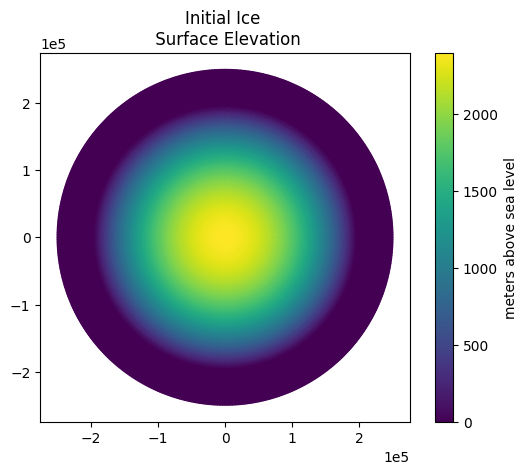

In [7]:
# Now we will put an Initial ice sheet on this bed

from firedrake import max_value

# surface elevation
max_radius = 195e3
dome_height = 2.4e3
dome = dome_height*max_value(1-(x**2 + y**2)/(max_radius**2), 0)
s0 = Function(Q).interpolate(dome)

# thickness
h0 = Function(Q).interpolate(max_value(s0 - b, 0))
print(h0)

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s0, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Initial Ice \n Surface Elevation");

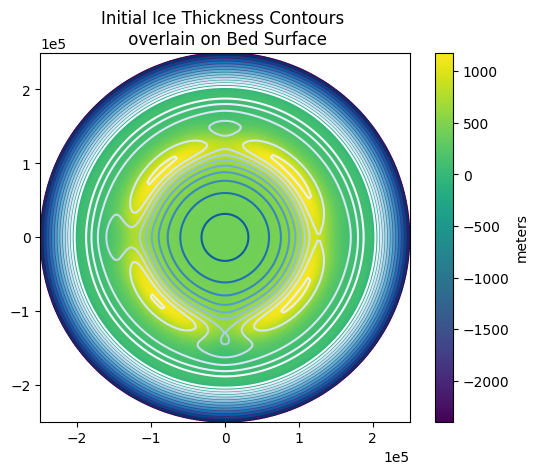

In [8]:
fig, axes = icepack.plot.subplots()
colors_b = firedrake.tripcolor(b, axes=axes)
levels = np.linspace(100, 2300, 13)
contours_h = firedrake.tricontour(h0, levels, axes=axes, cmap="Blues")
fig.colorbar(colors_b, label="meters")
axes.set_title("Initial Ice Thickness Contours \n overlain on Bed Surface");

## Modeling

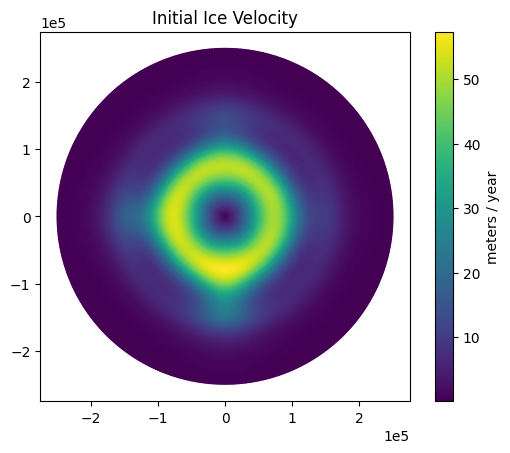

In [9]:
import icepack
model = icepack.models.ShallowIce()

# solve the problem; intializa the flow solver
solver = icepack.solvers.FlowSolver(model) # initialize the flow solver with any argument that never changes throughout the simulation 

# Fluidity factor A
T = Constant(273.15 -5)
A = icepack.rate_factor(T)

# compute the velocity field- call the diagnostic solver
u0 = firedrake.Function(V) # pass in an empty function since we have no initial velocity field
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    surface=s0,
    fluidity=A,
)
# Note: this solver takes in the intial velocity of the ice field, thickness, surface, and fluidity factor as arguments and returns the velocity field

# plot the velocity field
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year")
axes.set_title("Initial Ice Velocity");


In [10]:
u

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1053bef40>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 46)

In [11]:
# To evolve the ice sheet, we will need to choose a mass balance field

from firedrake import min_value
def mass_balance(s,max_a=0.5,da_ds=0.5/1000,ela=300.9):
    return min_value((s-ela)*da_ds, max_a)

ela = 300
max_a = 0 
da_ds = 0

a = mass_balance(s0,ela=ela, max_a=max_a, da_ds=da_ds)


In [12]:
import tqdm

In [13]:

# # General simulation without any checkpoints ==========
# # TO project the state of the ice sheet in time we will call the prognostic solver routine to update the ice thickness and then call the diagnostic solver to update the velocity field given current thickness.

# # the following code runs the model forward 500 years with a 10 year time step until the ice sheet reaches steady state.
# dt = 10
# num_years = 500
# num_timesteps = int(num_years/dt)

# dh_max = np.zeros(num_timesteps)*np.nan
# a = Function(Q)

# for step in tqdm.trange(num_timesteps):
#     h_old = h.copy(deepcopy=True)
#     h = solver.prognostic_solve(
#         dt,
#         thickness=h,
#         accumulation=a,
#         velocity=u,
#     )

#     h.interpolate(max_value(h, 0))
#     s = Function(Q).interpolate(b + h)
#     u = solver.diagnostic_solve(
#         velocity=u,
#         thickness=h,
#         surface=s,
#         fluidity=A,
#     )

#     a.interpolate(mass_balance(s,ela=ela, max_a=max_a, da_ds=da_ds))

#     dh = Function(Q).interpolate(h - h_old)
#     dh_max[step] = dh.dat.data_ro.max()

## Apply Data Assmilation to Icepack

In [14]:
def shallowIce_icepack(dt, h, u, b, a, ela, max_a, da_ds,step,dh_max):

    # h and u are arrays convert then to firedrake functions
    if isinstance(h, np.ndarray):
        # Assuming `h` is a 1D array, project it into the function space `Q`
        h_function = Function(Q)
        h_function.dat.data[:] = h[:]  # Assign NumPy array values to the Function data
        h = h_function

    if isinstance(u, np.ndarray):
        u_function = Function(V)
        u_function.dat.data[:,:] = u[:,:]
        u = u_function

    h_old = h.copy(deepcopy=True)
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        accumulation=a,
        velocity=u,
    )

    h.interpolate(max_value(h, 0))
    s = Function(Q).interpolate(b + h)
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
    )

    a.interpolate(mass_balance(s,ela=ela, max_a=max_a, da_ds=da_ds))

    dh = Function(Q).interpolate(h - h_old)
    dh_max[step] = dh.dat.data_ro.max()

    # convert the firedrake functions to arrays
    h = h.dat.data_ro
    u = u.dat.data_ro
    s = s.dat.data_ro
    dh = dh.dat.data_ro

    return h, s, u, a, dh, dh_max


In [15]:
# Observation operators
def Obs(u):
    w = u
    return w

def JObs(u):
    n = len(u)
    D = np.eye(n)
    return D

# def Obs(huxg_virtual_obs, m_obs):
#     # Determine the size of the observation vector
#     n = huxg_virtual_obs.shape[0]
#     m = m_obs

#     # Initialize the H matrix with zeros
#     H = np.zeros((m * 2 + 1, n))

#     # Calculate the distance between measurements
#     di = int((n - 2) / (2 * m))  # Python uses int for integer division

#     # Fill in the H matrix
#     for i in range(m):
#         H[i, i * di] = 1
#         H[m + i, int((n - 2) / 2) + i * di] = 1


#     # Final element of H matrix
#     H[m * 2, n - 2] = 1  # Adjust for 0-based indexing

#     # Perform matrix multiplication
#     z = H @ huxg_virtual_obs  # '@' operator for matrix multiplication in Python
#     return z

# # Jacobian of the observation operator ----------------------
# def JObs(n_model, m_obs):
#     # Initialize the H matrix with zeros
#     n = n_model
#     m = m_obs
#     H = np.zeros((m * 2 + 1, n))

#     # Calculate the distance between measurements
#     di = int((n - 2) / (2 * m))  # Convert distance to an integer

#     # Fill in the H matrix
#     for i in range(m):  # Python uses 0-based indexing
#         H[i, i * di] = 1  # Adjust for 0-based indexing
#         H[m + i, int((n - 2) / 2) + i * di] = 1  # Adjust for 0-based indexing

#     # Final element of H matrix
#     H[m * 2, n - 2] = 1  # Adjust for 0-based indexing

#     return H

In [16]:
# Ensemble Kalman Filters
def EnKF(ubi,w,ObsOp,JObsOp,R,B):
    
    # The analysis step for the (stochastic) ensemble Kalman filter 
    # with virtual observations
    if ubi.ndim == 3:
        n,N = ubi.shape[0], ubi.shape[1]
    else:
        n,N = ubi.shape
    # n,N = ubi.shape # n is the state dimension and N is the size of ensemble
    m = w.shape[0] # m is the size of measurement vector

    # compute the mean of forecast ensemble
    ub = np.mean(ubi,1)    
    # compute Jacobian of observation operator at ub
    Dh = JObsOp(w)
    # compute Kalman gain
    print(Dh.shape, B.shape, R.shape)
 
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)
        
    
    wi = np.zeros([m,N])
    uai = np.zeros([n,N])
    for i in range(N):
        # create virtual observations
        # wi[:,i] = w + np.random.multivariate_normal(np.zeros(m), R)
        wi[:,i] = w + np.random.normal(0, np.sqrt(R))
        # compute analysis ensemble
        uai[:,i] = ubi[:,i] + K @ (wi[:,i]-ObsOp(ubi[:,i]))
        
    # compute the mean of analysis ensemble
    ua = np.mean(uai,1)    
    # compute analysis error covariance matrix
    P = (1/(N-1)) * (uai - ua.reshape(-1,1)) @ (uai - ua.reshape(-1,1)).T
    return uai, P

# # EnKF analysis step function ------------------------------
# def EnKF(huxg_ens, huxg_obs, ObsFun, JObsFun, Cov_obs, Cov_model, params, taper=None):
#     """
#     Analysis step of the Ensemble Kalman Filter (EnKF).
    
#     huxg_ens: ndarray (n x N) - The ensemble matrix of model states (n is state size, N is ensemble size).
#     huxg_obs: ndarray (m,) - The observation vector (m is measurement size).
#     ObsFun: Function - Observation function.
#     JObsFun: Function - Jacobian of the observation function.
#     Cov_obs: ndarray (m x m) - Observation covariance matrix.
#     Cov_model: ndarray (n x n) - Model covariance matrix.
#     params: dict - Dictionary containing parameters like "m_obs".
#     taper: ndarray (n x n) - Covariance taper matrix.
    
#     Returns:
#     analysis_ens: ndarray (n x N) - The updated ensemble after analysis.
#     analysis_cov: ndarray (n x n) - The updated covariance after analysis.
#     """
#     n, N = huxg_ens.shape  # n is the state size, N is the ensemble size
#     m = huxg_obs.shape[0]  # Measurement size (m)

#     # Compute the ensemble mean
#     huxg_ens_mean = np.mean(huxg_ens, axis=1, keepdims=True)  # mean of model forecast ensemble
    
#     # Compute the Jacobian of the observation operator
#     Jobs = JObsFun(n, params["m_obs"])  # Jacobian of the observation operator
    
#     # Compute the Kalman Gain
#     KalGain = Cov_model @ Jobs.T @ np.linalg.inv(Jobs @ Cov_model @ Jobs.T + Cov_obs)

#     # Initialize variables
#     obs_virtual = np.zeros((m, N))  # Virtual observations for the ensemble
#     analysis_ens = np.zeros_like(huxg_ens)  # Analysis ensemble

#     # Perform the analysis for each ensemble member
#     for i in range(N):
#         # Generate virtual observations using multivariate normal distribution
#         obs_virtual[:, i] = huxg_obs + np.random.multivariate_normal.rvs(mean=np.zeros(m), cov=Cov_obs)

#         # Update the ensemble member with the Kalman gain
#         analysis_ens[:, i] = huxg_ens[:, i] + KalGain @ (obs_virtual[:, i] - ObsFun(huxg_ens[:, i], params["m_obs"]))
    
#     # Compute the mean of the analysis ensemble
#     analysis_ens_mean = np.mean(analysis_ens, axis=1, keepdims=True)
    
#     # Compute the analysis error covariance
#     analysis_cov = (1 / (N - 1)) * (analysis_ens - analysis_ens_mean) @ (analysis_ens - analysis_ens_mean).T
#     # analysis_cov = analysis_cov * taper  # Apply covariance tapering
    
#     return analysis_ens, analysis_cov

In [17]:
# Ensemble parameters
dt = 10
tm = 500
nt = int(tm/dt)
t = np.linspace(0,tm,nt+1)

#  initial conditions
np.random.seed(seed=1)
sig_m = 0.15 
# R = sig_m**2 * np.eye(3) # observation error covariance matrix

dt_m = 15 # time interval between observations
tm_m = 150 # maximum time of observations
nt_m = int(tm_m/dt_m) # number of observations instants
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int) # indexes of observation instants
t_m = t[ind_m] # time instants of observations

sig_b= 0.1
# Q = 0.0*np.eye(3)
nd = h.dat.data_ro.shape[0]

B = sig_b**2*np.eye(nd)
ub = np.zeros([nd,nt+1])
# ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
# ua[:,0] = u0b
n = nd #state dimension
m = nd #measurement dimension
# ensemble size
N = 10

# no of observations
mobs = 10 
params = {"m_obs": mobs}
R = sig_m**2 * np.eye(nd) # observation error covariance matrix

# time integration
dh_max = np.zeros(nt)*np.nan
a = Function(Q)

s = Function(Q).interpolate(b + h.interpolate(max_value(h, 0)))
h_old = h.copy(deepcopy=True)
dh = Function(Q).interpolate(h - h_old)


h0 = h.copy(deepcopy=True)
u0 = u.copy(deepcopy=True)
dh0 = dh.copy(deepcopy=True)
s0 = s.copy(deepcopy=True)

# ndl = h_old.dat.data_ro.shape[0]
uval = np.zeros([nd,2,nt+1])
hval = np.zeros([nd,nt+1])
sval = np.zeros([nd,nt+1])
dhval = np.zeros([nd,nt+1])
uval[:,:,0] = u.dat.data_ro
hval[:,0] = h.dat.data_ro
sval[:,0] = s.dat.data_ro
dhval[:,0] = dh.dat.data_ro

km = 0
wu = np.zeros([nd,2,nt_m])
wh = np.zeros([nd,nt_m])
ws = np.zeros([nd,nt_m])
wdh = np.zeros([nd,nt_m])
for step in tqdm.trange(nt):
    hval[:,step+1], sval[:,step+1], uval[:,:,step+1] , a,  dhval[:,step+1], dh_max = \
                             shallowIce_icepack(dt, h, u, b, a, ela, max_a, da_ds, step, dh_max)

    if (km<nt_m) and (step+1 == ind_m[km]):
        wu[:,:,km] = Obs(uval[:,:,step+1]) + np.random.normal(0,sig_m,[nd,2])
        wh[:,km] = Obs(hval[:,step+1]) + np.random.normal(0,sig_m,nd)
        ws[:,km] = Obs(sval[:,step+1]) + np.random.normal(0,sig_m,nd)
        wdh[:,km] = Obs(dhval[:,step+1]) + np.random.normal(0,sig_m,nd)
        km = km + 1

100%|██████████| 50/50 [00:11<00:00,  4.43it/s]


In [18]:
# Obs(uval[:,:,1],params["m_obs"]).shape

In [19]:
# initialize the ensemble 
uai = np.zeros([nd,2,N])
hai = np.zeros([nd,N])
sai = np.zeros([nd,N])
dhai = np.zeros([nd,N])
for i in range(N):
    uai[:,:,i] = u0.dat.data_ro +  np.random.normal(0,sig_m,[nd,2])
    hai[:,i] = h0.dat.data_ro + np.random.normal(0,sig_m,nd)
    sai[:,i] = s0.dat.data_ro + np.random.normal(0,sig_m,nd)
    dhai[:,i] = dh0.dat.data_ro + np.random.normal(0,sig_m,nd)

In [20]:
# Apply the EnKF
ub = np.zeros([nd,2,nt+1]); ub[:,:,0] = u0.dat.data_ro
hb = np.zeros([nd,nt+1]); hb[:,0] = h0.dat.data_ro
sb = np.zeros([nd,nt+1]); sb[:,0] = s0.dat.data_ro
dhb = np.zeros([nd,nt+1]); dhb[:,0] = dh0.dat.data_ro

ua = np.zeros([nd,2,nt+1]); ua[:,:,0] = u0.dat.data_ro
ha = np.zeros([nd,nt+1]); ha[:,0] = h0.dat.data_ro
sa = np.zeros([nd,nt+1]); sa[:,0] = s0.dat.data_ro
dha = np.zeros([nd,nt+1]); dha[:,0] = dh0.dat.data_ro

ua = np.zeros([nd,2,nt+1])
ha = np.zeros([nd,nt+1])
sa = np.zeros([nd,nt+1])
dha = np.zeros([nd,nt+1])

km = 0
for k in tqdm.trange(nt):
    # background state
    hb[:,k+1], sb[:,k+1], ub[:,:,k+1], a, dhb[:,k+1], dh_max = \
                    shallowIce_icepack(dt,hb[:,k],ub[:,:,k],b,a,ela,max_a,da_ds,k,dh_max)
    
    # forecast step
    for i in range(N):
        hai[:,i], sai[:,i], uai[:,:,i], a, dhai[:,i], dh_max = \
                    shallowIce_icepack(dt,hai[:,i],uai[:,:,i],b,a,ela,max_a,da_ds,k,dh_max) 
        uai[:,:,i] = uai[:,:,i] + np.random.normal(0,sig_m,[nd,2])
        hai[:,i] = hai[:,i] + np.random.normal(0,sig_m,nd)
        sai[:,i] = sai[:,i] + np.random.normal(0,sig_m,nd)
        dhai[:,i] = dhai[:,i] + np.random.normal(0,sig_m,nd)
        
    # compute the mean of the forecast ensemble
    ua[:,:,k+1] = np.mean(uai,2)
    ha[:,k+1] = np.mean(hai,1)
    sa[:,k+1] = np.mean(sai,1)
    dha[:,k+1] = np.mean(dhai,1)

    # compute the forecast error covariance matrix
    # Bu = (1/(N-1)) * (uai - ua[:,:,k+1].reshape(-1,2,1)) @ (uai - ua[:,:,k+1].reshape(-1,2,1)).transpose(0,2,1)
    Bh = (1/(N-1)) * (hai - ha[:,k+1].reshape(-1,1)) @ (hai - ha[:,k+1].reshape(-1,1)).T
    Bs = (1/(N-1)) * (sai - sa[:,k+1].reshape(-1,1)) @ (sai - sa[:,k+1].reshape(-1,1)).T
    Bdh = (1/(N-1)) * (dhai - dha[:,k+1].reshape(-1,1)) @ (dhai - dha[:,k+1].reshape(-1,1)).T

    if (km<nt_m) and (k+1 == ind_m[km]):
        # analysis step
        # uai, Bu = EnKF(uai,wu[:,:,km],Obs,JObs,R,Bu)
        hai, Bh = EnKF(hai,wh[:,km],Obs,JObs,R,Bh)
        # sai, Bs = EnKF(sai,ws[:,km],Obs,JObs,R,Bs)
        # dhai, Bdh = EnKF(dhai,wdh[:km],Jbs,DObs,R,Bdh)

        # compute the mean of the analysis ensemble
        ua[:,:,k+1] = np.mean(uai,2)
        # ha[:,k+1] = np.mean(hai,1)
        # sa[:,k+1] = np.mean(sai,1)
        # dha[:,k+1] = np.mean(dhai,1)
        km = km + 1



  0%|          | 0/50 [00:00<?, ?it/s]

(16641, 16641) (16641, 16641) (16641, 16641)


  0%|          | 0/50 [03:18<?, ?it/s]


ValueError: could not broadcast input array from shape (16641,16641) into shape (16641,)

In [ ]:
# We will plot the final ice thickness and velocity fields. 

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(u, axes=axes)
fig.colorbar(colors, label="meters / year")
axes.set_title("Final Ice Velocity")

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(s, axes=axes)
fig.colorbar(colors, label="meters above sea level")
axes.set_title("Final Ice \n Surface Elevation")

In [ ]:
#we will also look at how much the ice thickness has changed compoared to the original last time step.

fig, axes = icepack.plot.subplots()
thickness_change = Function(Q).interpolate(h - h0)
colors = firedrake.tripcolor(
    thickness_change, vmin=-300, vmax=+300, axes=axes, cmap="RdBu"
)
fig.colorbar(colors, label="meters")
axes.set_title("Final - Initial\nIce Thickness")


# If we plot the incremental change in thickness, then we can get a better sense of how close the ice sheet is to steady state.

fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(
    dh, vmin=-10, vmax=+10, axes=axes, cmap="RdBu"
)
fig.colorbar(colors, label="meters")
axes.set_title("Final - Previous\nIce Thickness")



In [ ]:
# If we plot the maximum change in thickness through time, we can see how the ice sheet is approaching steady state.

plt.figure()
plt.plot(dt * np.arange(nt), dh_max)
plt.xlabel("years")
plt.ylabel("maximum change in thickness (meters)")
axes.set_title("Max Change in Ice Thickness at each Time Step")

In [36]:
import os
import numpy as np
import h5py
import tqdm
# ---- under construction ----
# Simulation parameters
dt = 10  # Time step in years
num_years = 400  # Total number of years to simulate
num_timesteps = int(num_years / dt)
save_interval = 50  # Save every 50 years

# Restart parameters
restart_flag = False  # Whether to restart from a previous simulation
save_restarts_flag = False  # Whether to save restart files
added_time = 100 # Add 100 years to the simulation
new_time = num_years + added_time
new_timesteps = int(new_time / dt)
restart_dir = "restarts"  # Directory to save the restart files

# Ensure the restart directory exists
if not os.path.exists(restart_dir):
    os.makedirs(restart_dir)

# Utility function to generate restart file names
def get_hdf5_filename(step):
    return os.path.join(restart_dir, f"restart_{step}_years.h5")

# Load restart file
def load_restart_file(step):
    print(f"Loading restart file for step {step}...")

    hdf5_file = get_hdf5_filename(step)
    with h5py.File(hdf5_file, 'r') as f:
        dh_max = np.array(f['dh_max'])
        step = int(f['step'][()])
        h_data = f['h'][:]
        u_data = f['u'][:]

    return dh_max, step, h_data, u_data

# Save restart file
def save_restart_file(step, dh_max, h, u):
    print(f"Saving restart file at step {step}...")

    hdf5_file = get_hdf5_filename(step)
    with h5py.File(hdf5_file, 'w') as f:
        f.create_dataset('dh_max', data=dh_max)
        f.create_dataset('step', data=step)
        f.create_dataset('h', data=h.dat.data_ro)  # Save ice thickness as array
        f.create_dataset('u', data=u.dat.data_ro)  # Save velocity as array

latest_restart = None
restart_files = sorted(os.listdir(restart_dir)) if os.path.exists(restart_dir) else []
if restart_files:
    latest_restarts = []
    for i in range(len(restart_files)):
        lr = int(restart_files[i].split('_')[1])  
        latest_restarts.append(lr)

    latest_restart = max(latest_restarts)

# override the last restart file
latest_restart = latest_restart #choose the latest restart file

if not save_restarts_flag:  os.system("rm -rf restarts")

# Initialize or load from the latest restart file
if latest_restart and restart_flag:
    dh_max, step, h_data, u_data = load_restart_file(latest_restart)
    hfun = Function(Q)  # Rebuild the Function object for thickness
    ufun = Function(V)  # Rebuild the Function object for velocity
    h.dat.data[:] = h_data  # Assign the loaded data to the Function
    u.dat.data[:,:] = u_data[:, :]
    print(f"Restarting from year {latest_restart}")
else:
    # If no restart, start from the beginning
    dh_max = np.zeros(num_timesteps) * np.nan  # Initialize dh_max array
    step = 0  # Start from the beginning
    h = h0.copy(deepcopy=True)  # Initialize ice thickness from the initial condition
    u = solver.diagnostic_solve(
        velocity=u0,
        thickness=h,
        surface=s0,
        fluidity=A,
    )
    print("Starting from the beginning")

# Initialize accumulation
a = Function(Q)

if restart_flag and added_time > 0:
    num_timesteps = new_timesteps
    dh_max = np.zeros(num_timesteps)*np.nan
else:
    dh_max = np.zeros(num_timesteps)*np.nan

# Main simulation loop (either from step 0 or from the last saved step)
for step in tqdm.trange(step, num_timesteps):
    h_old = h.copy(deepcopy=True)  # Save the old thickness

    # Prognostic solve (updating ice thickness)
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        accumulation=a,
        velocity=u,
    )

    # Interpolate the thickness
    h.interpolate(max_value(h, 0))
    s = Function(Q).interpolate(b + h)

    # Diagnostic solve (updating velocity)
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
    )

    # Update accumulation (mass balance)
    a.interpolate(mass_balance(s, ela=ela, max_a=max_a, da_ds=da_ds))

    # Calculate dh and track max dh values
    dh = Function(Q).interpolate(h - h_old)
    dh_max[step] = dh.dat.data_ro.max()

    # Save restart file every 50 years or when simulation is done
    restart_save_flag = (step + 1) % (save_interval / dt) == 0 or step == num_timesteps - 1
    if save_restarts_flag and restart_save_flag:
        save_restart_file(step, dh_max, h, u)
        # save data for visualization



Starting from the beginning


100%|██████████| 40/40 [00:08<00:00,  4.88it/s]


Text(0.5, 1.0, 'Max Change in Ice Thickness at each Time Step')

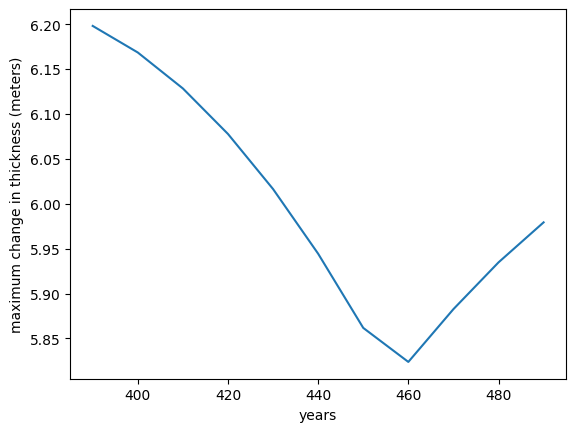

In [30]:
# If we plot the maximum change in thickness through time, we can see how the ice sheet is approaching steady state.

plt.figure()
plt.plot(dt * np.arange(nt), dh_max)
plt.xlabel("years")
plt.ylabel("maximum change in thickness (meters)")
axes.set_title("Max Change in Ice Thickness at each Time Step")